# Optimal Extraction Algorithm
## Introduction

Optimal extraction is an advance method to extract a _1D_ spectrum from a _2D_ spectrum image (See [Marsh, 1989], [Horne, Keith. 1986]). Normally you would just sum up a number of lines along the spatial direction for the whole dispersion direction to obtain a _1D_ spectrum in counts, but there are the _Cosmic Rays_. Cosmic Rays create a very distinctive feature in the image and it will look very similar to a hot pixel, they have to be masked out.


## Find the best fitting model

First we load some packages

In [30]:
from ccdproc import CCDData
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
import astropy.units as u
import numpy as np


Now we load a sample image. Displayed below.

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [ccdproc.ccddata]


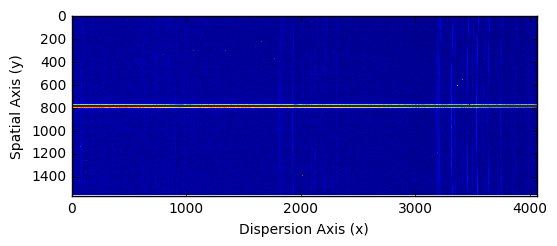

In [31]:

sample_file  = '/data/simon/data/soar/work/20161114_eng_3/RED4/cfzsto_0216_EG21_1200M5_GG455.fits' #cfzsto_0199_EG21_400M2_GG455.fits'
ccd = CCDData.read(sample_file, unit=u.adu)

plt.imshow(ccd.data, clim=(0, 350))
plt.xlabel('Dispersion Axis (x)')
plt.ylabel('Spatial Axis (y)')
plt.show()

Cutting the image at a _random_ location we can see the profile. This profile is affected by the instrument and the seeing.

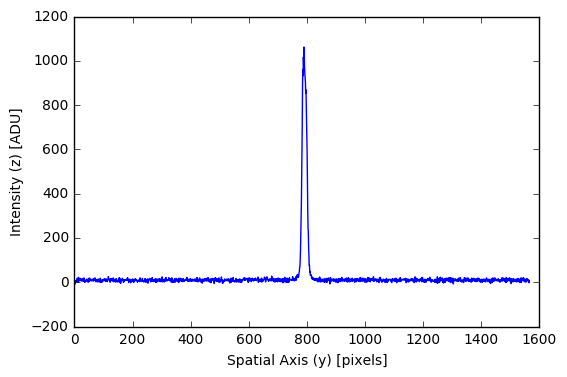

In [32]:
plt.plot(ccd.data[:,500])
plt.xlabel('Spatial Axis (y) [pixels]')
plt.ylabel('Intensity (z) [ADU]')
plt.show()

Let's define a function that will do a fit and plot both the data and the model as well as the residues.

In [33]:
voigt_model = models.Voigt1D(x_0=100, amplitude_L=500, fwhm_L=8, fwhm_G=8).rename('Voigt')
gauss_model = models.Gaussian1D(amplitude=500, mean=100, stddev=8).rename('Gaussian')
lorentz_model = models.Lorentz1D(x_0=100, amplitude=500, fwhm=8).rename('Lorentz')
all_model = [voigt_model, gauss_model, lorentz_model]
fitter = fitting.LevMarLSQFitter()

def fit_profile(column, all_model, fitter):
    sample_data = np.median(ccd.data, axis=1)
    x_axis = range(len(sample_data))
    max_value = np.max(sample_data)
    fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
    ax1.plot(x_axis, sample_data, color='k', label='Data')
    ax2.set_xlabel('Pixel (Spatial Direction)')
    ax1.set_ylabel('Intensity (ADU)')
    ax2.set_ylabel('RMSE')
    colors = ['r','g','c']
    all_fitted_models = []
    for model in all_model:
        # center
        try:
            model.x_0.value = column
        
        except AttributeError:
            model.mean.value = column
        # Amplitude   
        try:
            model.amplitude_L = max_value
        except AttributeError:
            model.amplitude = max_value
        # The actual fitting
        fitted_profile = fitter(model, x_axis, sample_data)
        all_fitted_models.append(fitted_profile)
        difference = np.sqrt((sample_data - fitted_profile(x_axis)) ** 2)
        color = colors.pop()
        ax1.plot(x_axis, fitted_profile(x_axis), color=color, label=model.name)
        ax1.legend(loc='best')
        ax1.set_xlim((column - 150, column + 150))
        ax2.plot(x_axis, difference, color=color, label='RMS {:s}'.format(model.name))
        ax2.set_ylim(ax1.get_ylim())
        ax2.legend(loc='best')
    plt.show()
    return x_axis, all_fitted_models
    

Now we can call it for all the profiles.

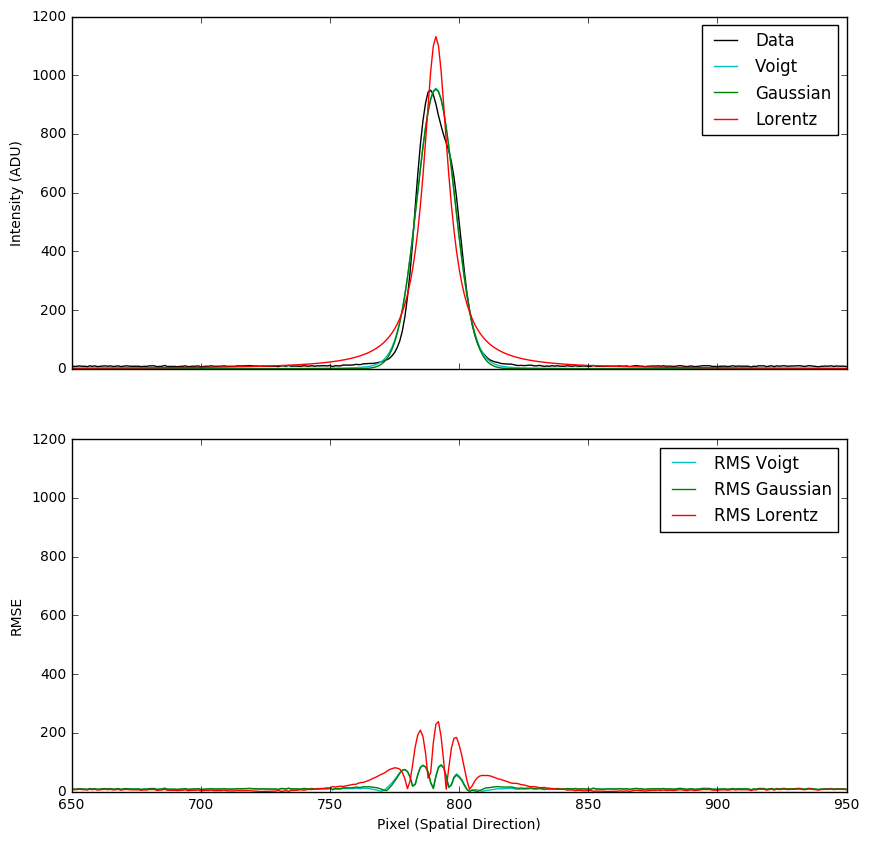

In [34]:
x_axis, all_fitted_models = fit_profile(column=800, all_model=all_model, fitter=fitter)

## Initial Variance Estimate
$$V_{x\lambda} = V_0 + \left|D_{x\lambda}\right|/Q$$

_Where $\sqrt{V_0}$ is the root-mean-squared readout noise in data numbers and $Q$ is the effective number of photons per data number_

So it seems clear that the best fit is a gaussian.

## Finding Weights

First we recover the _Gaussian_ fitted model 
                                 

Model: Gaussian1D
Name: Gaussian
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude        mean         stddev   
    ------------- ------------- -------------
    952.573989953 791.007675797 7.36105926131


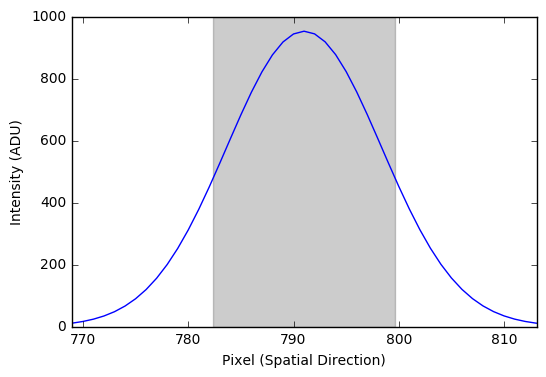

In [35]:
# x_axis = 
gaussian = (model for model in all_fitted_models if model.name == 'Gaussian').next()
print(gaussian)
fwhm = 2.355 * gaussian.stddev.value
xmin = gaussian.mean.value - 3 * gaussian.stddev.value
xmax = gaussian.mean.value + 3 * gaussian.stddev.value
plt.xlim(xmin, xmax)
plt.axvspan(gaussian.mean.value - 0.5 * fwhm, gaussian.mean.value + 0.5 * fwhm, color='k', alpha=.2, label='FWHM')
plt.plot(gaussian(x_axis))
plt.xlabel('Pixel (Spatial Direction)')
plt.ylabel('Intensity (ADU)')
plt.show()

### Enforce Positivity
In this example there is no sign of negative values, however it could happen. Let $P$ be the spatial profile

$$ P = MAX[P;0]$$

In [36]:
gaussian_values = gaussian(x_axis)
rxmin = int(round(xmin))
rxmax = int(round(xmin))
print(xmin, xmax)


# print(np.min(gaussian_values))
gaussian_positive = np.array([np.max(pixel, 0) for pixel in gaussian_values])

(768.92449801335761, 813.09085358121843)



### Enforce Normalization
In order to normalize the profile
$$P_{xy}=\frac{D_{xy}}{\sum_yD_{xy}}$$

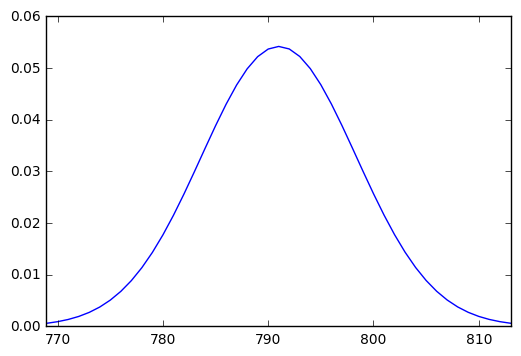

Normalized Profile Sum: 1.000


In [37]:
norm_profile = np.array([x / gaussian_positive.sum() for x in gaussian_positive])

plt.plot(norm_profile)
plt.xlim(xmin, xmax)
plt.show()
print('Normalized Profile Sum: {:.3f}'.format(norm_profile.sum()))

## Get variance 2D

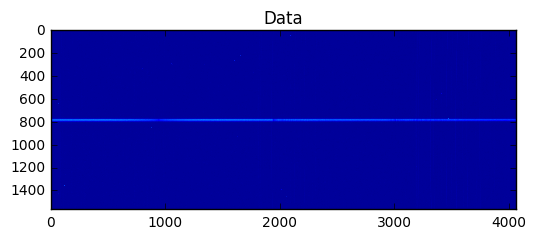

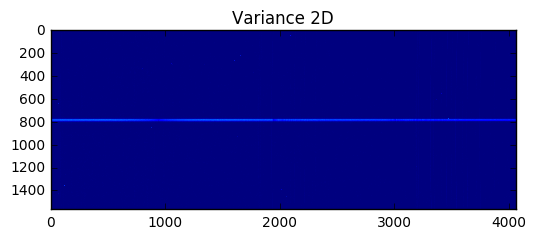

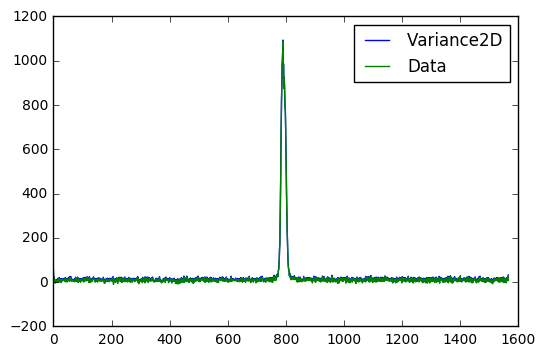

In [39]:
rdnoise = float(ccd.header['RDNOISE'])
gain = float(ccd.header['GAIN'])
variance2d = (rdnoise + np.absolute(ccd.data) * gain) / gain

plt.title('Data')
plt.imshow(ccd.data)
plt.show()

plt.title('Variance 2D')
plt.imshow(variance2d)
plt.show()

plt.plot(variance2d[:,1500], label='Variance2D')
plt.plot(ccd.data[:,1500], label='Data')
plt.legend(loc='best')
plt.show()